# Mirror-based Extrinsic Camera Calibration

## Goal

The goal of this notebook is to calibrate the extrinsic parameter of a camera w.r.t. a reference object (e.g., chessboard) that is not directly visible from the camera.  The key idea is to capture the reference object through a mirror.  As described in the papers below, we can calibrate the camera and the mirror poses w.r.t. the reference object using 3 or more images taken with different mirror poses.

- [Kosuke Takahashi, Shohei Nobuhara, and Takashi Matsuyama, “Mirror-based Camera Pose Estimation Using an Orthogonality Constraint,” IPSJ Transactions on Computer Vision and Applications, vol. 8, pp. 11–19, Feb. 2016.](https://github.com/computer-vision/takahashi2012cvpr)
- [Kosuke Takahashi, Shohei Nobuhara, and Takashi Matsuyama, “A new mirror-based extrinsic camera calibration using an orthogonality constraint,” in Proc. of IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2012, pp. 1051–1058.](https://github.com/computer-vision/takahashi2012cvpr)

This technique can be used for calibrating a webcam-display system, non-overlapping cameras, and so forth.

## Outline

Consider a static 3D reference object with $N_p$ feature points ${p'}^{i} \; (i=1,\dots,N_p)$ in the scene, such as a chess patten shown in a flat display.  By observing the 3D reference object through a planar mirror $\pi_j \; (j=1,\dots,N_m)$ at $N_m$ different poses, the 3D reference object is mirrored as $p_j^i$ and is projected to $q_j^i$ in the camera image.

Given the 3D coordinates of $N_p$ feature points ${p'}^{i}$ in the model (= world) coordinate system and their projections $q_j^i$ in the $N_m$ images, we can calibrate

- the 3D pose $R$, $t$ of the camera, and
- the 3D normal $n_j$ and the distance $d_j$ of each mirror,

in the model coordinate system, i.e., w.r.t. the reference object.  In this calibration, the following assumptions should be met.

- The intrinsic parameter $K$ is given a priori.
- The 2D positions $p_j^i$ are given in the undistorted image coordinate.
- $N_p \ge 3$ (larger is better)
- $N_m \ge 3$ (larger is better)
- The mirror does not have a transparent layer on it, i.e., it is a [first-surface mirror](https://en.wikipedia.org/wiki/First-surface_mirror) without refraction.
- The mirror poses are _mutually independent_.  They are not parallel and do not intersect at a single axis.

In practice, it is strongly recommended to use a ChAruCo pattern as the reference object since we can easilly identify if the pattern is flipped (mirrored) or not.


## Input

This cell loads preprocessed files to prepare the following variables.  You can use your own data as long as the following conditions are satisfied.

- `cameraMatrix`: a $3 \times 3$ matrix calibrated beforehand
- `OBJ_PTS`: an $N_p \times 3$ matrix representing the 3D positions of the object points $P'^i$.
- `IMG_PTS`: an $N_m \times N_p \times 2$ matrix representing the 2D positions of the image points $p^i_j$.
  - If some points cannot be detected, fill them by `NaN`.  `np.loadtxt()` can parse `NaN` (string) as `np.nan` (float).
  - These 2D positions are supposed to be lens-undistorted.


In [1]:
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import pycalib

DATA_DIR = '../data/mirror/chess/'

K = np.loadtxt(f'{DATA_DIR}/camera.txt')
assert K.shape == (3, 3)

OBJ_PTS = np.loadtxt(f'{DATA_DIR}/model.txt')
Np = len(OBJ_PTS)
assert OBJ_PTS.shape == (Np, 3)

input1 = np.loadtxt(f'{DATA_DIR}/input1.txt')
input2 = np.loadtxt(f'{DATA_DIR}/input2.txt')
input3 = np.loadtxt(f'{DATA_DIR}/input3.txt')
input4 = np.loadtxt(f'{DATA_DIR}/input4.txt')
input5 = np.loadtxt(f'{DATA_DIR}/input5.txt')
IMG_PTS = np.array([input1, input2, input3, input4, input5])
Nm = len(IMG_PTS)
assert IMG_PTS.shape == (Nm, Np, 2)

print('Camera Matrix', K)
print('Object Points (Np x 3) = ', OBJ_PTS.shape)
print('Image Points (Nm x Np x 2) = ', IMG_PTS.shape)

Camera Matrix [[2.44572485e+03 0.00000000e+00 8.19293030e+02]
 [0.00000000e+00 2.44239160e+03 6.60130737e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Object Points (Np x 3) =  (70, 3)
Image Points (Nm x Np x 2) =  (5, 70, 2)


## Example 1: Full observation


In [2]:
# linear solution
R0, T0, n0, d0, rep0 = pycalib.mirror.tnm(OBJ_PTS, IMG_PTS, K)
print(f'Reprojection error (linear) = {rep0:.3} px')

# non-linear refinement
R, T, n, d, rep = pycalib.mirror.tnm_ba(OBJ_PTS, IMG_PTS, K, R0, T0, n0, d0)
print(f'Reprojection error (BA) = {rep:.3} px')


Reprojection error (linear) = 6.28 px
Reprojection error (BA) = 0.64 px


## Visualization

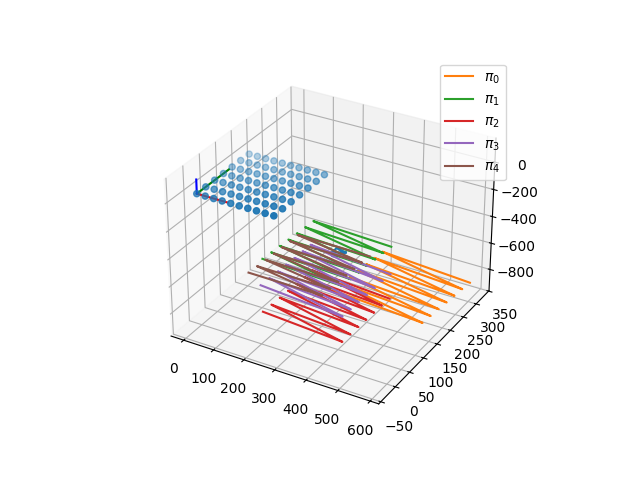

In [3]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Display
ax.scatter(OBJ_PTS[:,0], OBJ_PTS[:,1], OBJ_PTS[:,2])

# World coordinate system
ax.plot([0, 100], [0, 0], [0, 0], color='red')   # X
ax.plot([0, 0], [0, 100], [0, 0], color='green') # Y
ax.plot([0, 0], [0, 0], [0, 100], color='blue')  # Z

# Camera
pycalib.plot.plotCamera(ax, R.T, -R.T@T, scale=100//8)

# Mirror
for i, (ni, di) in enumerate(zip(n, d)):
    pycalib.plot.plotMirror(ax, OBJ_PTS, ni, di, rf'$\pi_{i}$')

plt.legend()
plt.show()

## Example 2: Missing observations


In [4]:
# drop randomly

TH = 90
rng = np.random.default_rng(0)
sign = rng.integers(0, 100, size=IMG_PTS.shape[:2])
IMG_PTS[sign<TH,:] = np.nan

print(f'{np.sum(np.isnan(IMG_PTS[:,:,0]))} out of {len(IMG_PTS.reshape((-1,2)))} points are masked out')

#print(IMG_PTS)

# linear solution
R0, T0, n0, d0, rep0 = pycalib.mirror.tnm(OBJ_PTS, IMG_PTS, K)
print(f'Reprojection error (linear) = {rep0:.3} px')

# non-linear refinement
R, T, n, d, rep = pycalib.mirror.tnm_ba(OBJ_PTS, IMG_PTS, K, R0, T0, n0, d0)
print(f'Reprojection error (BA) = {rep:.3} px')


311 out of 350 points are masked out
Reprojection error (linear) = 26.9 px
Reprojection error (BA) = 0.646 px
